In [1]:
# Cleaned & Parallelized Preprocessing Pipeline for MIMIC-III Symptom Extraction
import pandas as pd
import re
import spacy
from scispacy.umls_linking import UmlsEntityLinker
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing
from collections import Counter

# ----------------------------
# Step 1: Load and Filter Discharge Summaries
# ----------------------------
noteevents = pd.read_csv("NOTEEVENTS.csv.gz", 
                         usecols=["SUBJECT_ID", "HADM_ID", "CHARTDATE", "CATEGORY", "TEXT"],
                         compression="gzip", low_memory=False)

# Only keep 'Discharge summary' and drop null/duplicate notes
discharge_notes = noteevents[noteevents["CATEGORY"] == "Discharge summary"].copy()
discharge_notes.drop_duplicates(subset=["SUBJECT_ID", "HADM_ID", "TEXT"], inplace=True)
discharge_notes.dropna(subset=["TEXT"], inplace=True)

print(f"Loaded {len(discharge_notes)} clean discharge summaries.")

# Visualize all note types (before filtering)
plt.figure(figsize=(10, 4))
sns.countplot(data=noteevents, x="CATEGORY", order=noteevents["CATEGORY"].value_counts().index, palette="Set2")
plt.title("Note Categories in NOTEEVENTS")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Loaded 59652 discharge summaries.


In [2]:
# ----------------------------
# Step 2: Extract Relevant Clinical Sections
# ----------------------------

RELEVANT_HEADERS = {
    'HISTORY OF PRESENT ILLNESS', 'IMPRESSION', 'FINDINGS',
    'HOSPITAL COURSE', 'PHYSICAL EXAMINATION', 'CHIEF COMPLAINT',
    'PRESENTING COMPLAINT', 'ADMISSION DIAGNOSIS'
}

def extract_sections(text):
    sections = {}
    current_section = None
    lines = text.split('\n')
    for line in lines:
        line_stripped = line.strip()
        if re.match(r'^[A-Z][A-Z \-]*:$', line_stripped):  # detects section headers
            current_section = line_stripped[:-1].strip()
            sections[current_section] = []
        elif current_section:
            sections[current_section].append(line_stripped)

    kept = []
    for key in sections:
        for rel in RELEVANT_HEADERS:
            if rel in key:  # match substring instead of exact equality
                kept.extend(sections[key])
                break
    return ' '.join(kept).strip()

# Clean and filter
discharge_notes["TEXT_CLEAN"] = discharge_notes["TEXT"].fillna("").apply(extract_sections)
discharge_notes = discharge_notes[discharge_notes["TEXT_CLEAN"].str.len() > 0].copy()
print(f"Extracted clinical sections from {len(discharge_notes)} discharge notes.")

# Length of cleaned clinical text
discharge_notes["TEXT_LEN"] = discharge_notes["TEXT_CLEAN"].str.split().str.len()

plt.figure(figsize=(10, 4))
sns.histplot(discharge_notes["TEXT_LEN"], bins=50, kde=True)
plt.title("Length Distribution of Cleaned Discharge Text")
plt.xlabel("Token Count in Extracted Sections")
plt.ylabel("Number of Notes")
plt.tight_layout()
plt.show()

Cleaned and extracted relevant sections.


In [3]:
# ----------------------------
# Step 3: Load SciSpaCy Model and UMLS Linker
# ----------------------------
import os

print("Loading en_core_sci_lg model...")
try:
    nlp = spacy.load("en_core_sci_lg", exclude=["tok2vec", "parser", "attribute_ruler", "lemmatizer"])
except:
    print("Make sure the model is installed via: python -m spacy download en_core_sci_lg")

if "scispacy_linker" not in nlp.pipe_names:
    print("Adding UMLS linker to pipeline...")
    nlp.add_pipe("scispacy_linker", config={
        "resolve_abbreviations": True,
        "linker_name": "umls"
    })

linker = nlp.get_pipe("scispacy_linker")

print("Pipeline components:", nlp.pipe_names)

Loading en_core_sci_lg model...


C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_sci_lg' (0.5.1) was trained with spaCy v3.4.1 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Adding UMLS linker to pipeline...


C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Pipeline components: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner', 'scispacy_linker']


In [4]:
# ----------------------------
# Step 4: Efficient UMLS Symptom Extraction (Parallel)
# ----------------------------
TARGET_SEMANTIC_TYPES = {"T184", "T047", "T046", "T033"}  # Symptom, Disease, Sign, Pathological function
EXCLUDE_SYMPTOMS = {"pain", "problem", "issue", "discomfort", "distress", "weakness", "abnormality"}

symptom_lists = []
symptom_counter = Counter()

def extract_umls_symptoms(doc):
    symptoms = set()
    for ent in doc.ents:
        for umls_ent in ent._.kb_ents:
            cui_entry = linker.kb.cui_to_entity.get(umls_ent[0])
            if cui_entry and any(t in cui_entry.types for t in TARGET_SEMANTIC_TYPES):
                name = cui_entry.canonical_name.lower().strip()
                if name not in EXCLUDE_SYMPTOMS:
                    symptoms.add(name)
    return list(symptoms)

print("Running symptom extraction on all notes (parallel)...")
texts = discharge_notes["TEXT_CLEAN"].tolist()

# Filter out overly short clinical texts (<30 tokens)
filtered_indices = [i for i, text in enumerate(texts) if len(text.split()) >= 30]
filtered_texts = [texts[i] for i in filtered_indices]

n_cores = min(8, multiprocessing.cpu_count())  # conservative for memory; 3090 GPU can go higher if not multitasking
for doc in tqdm(nlp.pipe(filtered_texts, batch_size=32, n_process=1), total=len(filtered_texts)):
    syms = extract_umls_symptoms(doc)
    symptom_lists.append(syms)
    symptom_counter.update(syms)

# Rare term filtering (<3 occurrences)
symptom_lists = [[s for s in doc if symptom_counter[s] >= 3] for doc in symptom_lists]

# Reassign filtered rows
discharge_notes = discharge_notes.iloc[filtered_indices[:len(symptom_lists)]].copy()
discharge_notes["SYMPTOMS"] = symptom_lists
print(f"Symptom extraction complete. Retained {len(discharge_notes)} notes with symptom lists.")

# Most common symptoms (after filtering low-frequency ones)
common_symptoms = symptom_counter.most_common(30)
symptoms, counts = zip(*common_symptoms)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(symptoms), y=list(counts), palette="magma")
plt.title("Top 30 Extracted Symptoms After Frequency Filtering")
plt.xlabel("Symptom")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Running symptom extraction on all notes (parallel)...


100%|████████████████████████████████████████████████████████████████████████████| 11926/11926 [40:50<00:00,  4.87it/s]

Symptom extraction complete.


In [5]:
# ----------------------------
# Step 5: Join Notes with ICD-9 Labels & Filter Top Classes
# ----------------------------
diagnoses = pd.read_csv("DIAGNOSES_ICD.csv.gz", 
                        usecols=["HADM_ID", "ICD9_CODE"], 
                        compression="gzip", low_memory=False)
print(f"Loaded {len(diagnoses)} diagnosis entries.")

# Merge on HADM_ID (join symptoms with labels)
labeled = discharge_notes.merge(diagnoses, on="HADM_ID", how="inner")
print(f"Merged to {len(labeled)} labeled rows.")

# Count ICD-9 codes and select most frequent
icd_counts = labeled["ICD9_CODE"].value_counts()
top_k = 50
top_diagnoses = icd_counts.nlargest(top_k).index.tolist()
labeled_filtered = labeled[labeled["ICD9_CODE"].isin(top_diagnoses)].copy()
print(f"Filtered to top {top_k} ICD-9 codes.")

# Keep only one label per admission (drop multi-label)
labeled_filtered = labeled_filtered.sort_values(["HADM_ID", "ICD9_CODE"])
labeled_filtered = labeled_filtered.drop_duplicates("HADM_ID")
print(f"Final filtered dataset: {labeled_filtered.shape[0]} rows, {labeled_filtered['ICD9_CODE'].nunique()} classes.")


Loaded 651047 diagnosis entries.
Filtered to top 50 diagnoses: 49 classes


C:\Users\Allen\AppData\Local\Temp\ipykernel_6288\885589449.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index, y=top_counts.values, palette="viridis")


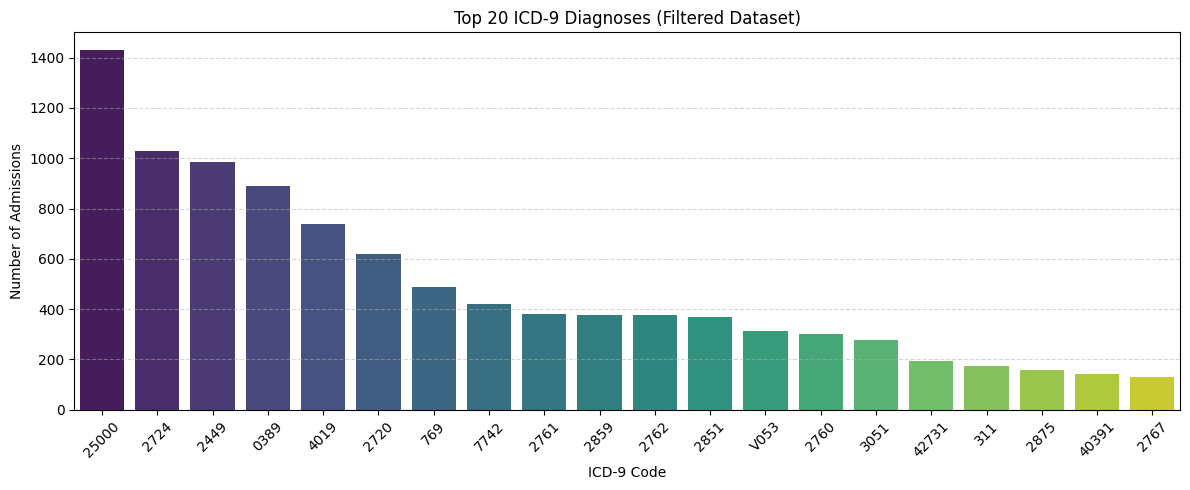

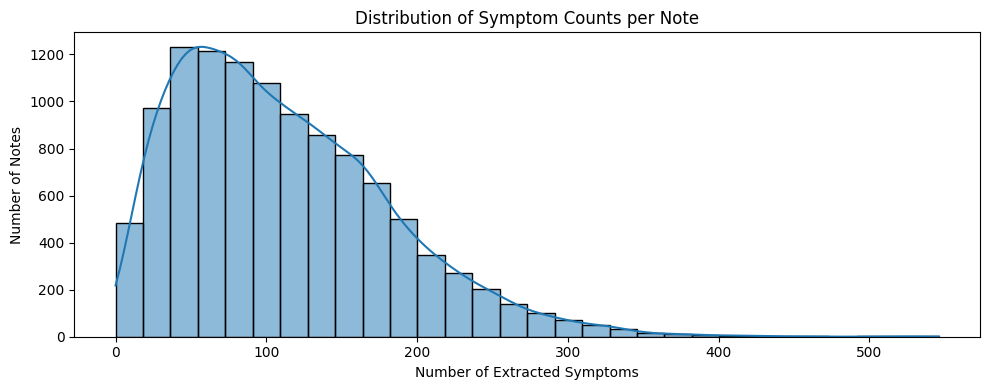

C:\Users\Allen\AppData\Local\Temp\ipykernel_6288\885589449.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=icd_grouped.index, y=icd_grouped.values, palette="coolwarm")


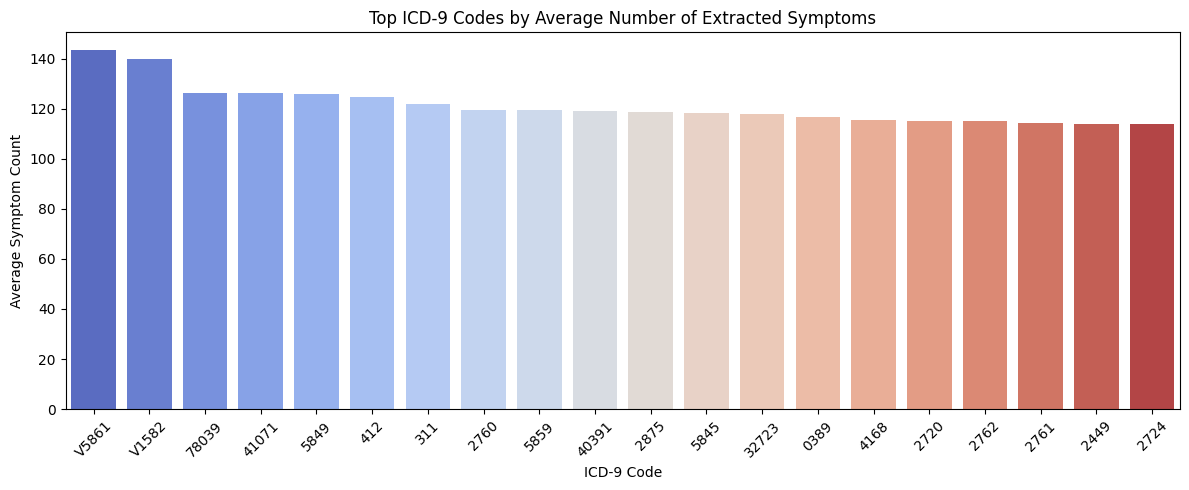

Saved preprocessed dataset to: labeled_notes_with_symptoms.csv
Final rows: 11138, Unique diagnoses: 49


In [8]:
# ----------------------------
# Step 6: Visualize Label Distribution & Export Final CSV
# ----------------------------
import seaborn as sns

# Visualize class frequency
top_counts = labeled_filtered["ICD9_CODE"].value_counts().head(20)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_counts.index, y=top_counts.values, palette="viridis")
plt.title("Top 20 ICD-9 Diagnoses (Filtered Dataset)")
plt.xlabel("ICD-9 Code")
plt.ylabel("Number of Admissions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Export final labeled dataset
output_path = "labeled_notes_with_symptoms.csv"
columns_to_export = ["HADM_ID", "SYMPTOMS", "ICD9_CODE"]
labeled_filtered[columns_to_export].to_csv(output_path, index=False)

# Distribution of number of extracted symptoms per note
labeled_filtered["SYMPTOM_COUNT"] = labeled_filtered["SYMPTOMS"].apply(len)

plt.figure(figsize=(10, 4))
sns.histplot(labeled_filtered["SYMPTOM_COUNT"], bins=30, kde=True)
plt.title("Distribution of Symptom Counts per Note")
plt.xlabel("Number of Extracted Symptoms")
plt.ylabel("Number of Notes")
plt.tight_layout()
plt.show()

icd_grouped = labeled_filtered.groupby("ICD9_CODE")["SYMPTOM_COUNT"].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 5))
sns.barplot(x=icd_grouped.index, y=icd_grouped.values, palette="coolwarm")
plt.title("Top ICD-9 Codes by Average Number of Extracted Symptoms")
plt.xlabel("ICD-9 Code")
plt.ylabel("Average Symptom Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Saved preprocessed dataset to: {output_path}")
print(f"Final rows: {labeled_filtered.shape[0]}, Unique diagnoses: {labeled_filtered['ICD9_CODE'].nunique()}")